# Diagnosing the sudden increase in `active` and `waiting` requests reported by nginx
This increase coincides with the rate of responses returned to the client dropping to 0.

In [1]:
import plot_utils
import rolling_funcs
from plot_utils import LogFile,LogFileType,Roller,Fig

WINDOW_SECS = 20.0

In [2]:
mean_roller = Roller('mean', rolling_funcs.mean)

response_rollers = [
    Roller("OK rate", rolling_funcs.count_ok, rate=True),
    Roller("ERR rate", rolling_funcs.count_err, rate=True, kwargs={'linestyle':'--'}),
]

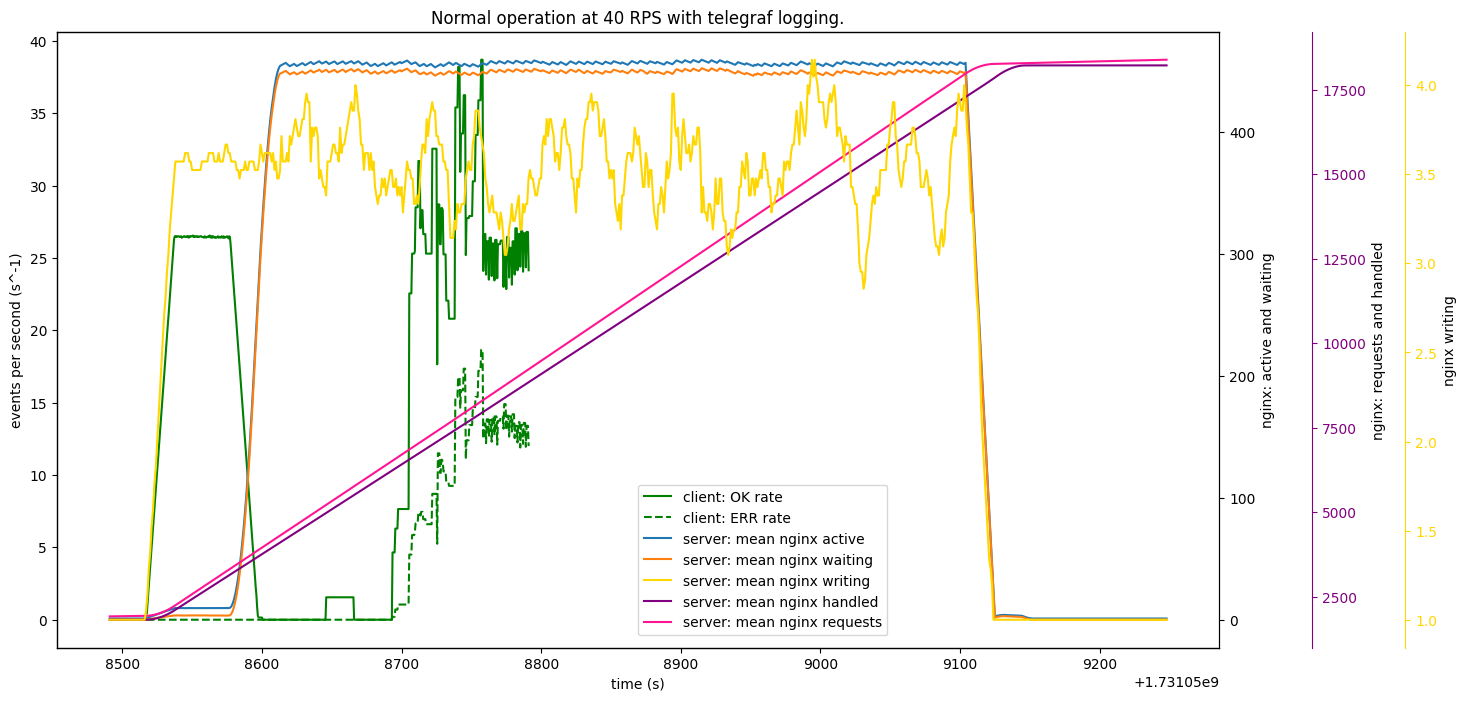

In [3]:
fig,ax = plot_utils.fig([
    Fig(title="Normal operation at 40 RPS with telegraf logging.",x="time (s)",y="events per second (s^-1)")
])

telegraf_log = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_09-35.json",
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})
nginx_handled = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_09-35.json",
kwargs={'telegraf': {
    'nginx' : [{'handled':{'color':'purple'}},{'requests':{'color':'deeppink'}}]
}, 'color':'purple'
})
nginx_writing = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_09-35.json",
kwargs={'telegraf': {
    'nginx' : ['writing']
}, 'color':'gold'
})
client_log = LogFile(log_type=LogFileType.GOT, path="./logs/kleene/2024-11-08_09-35-17.057625.txt",kwargs={'color':'g'})

ax_active,ax_handled,ax_writing = plot_utils.add_y_axes(
    ax, [('nginx: active and waiting','black'),('nginx: requests and handled','purple'),('nginx writing','gold')]
)

plot_utils.overlay_rolling(ax_active, {'server': telegraf_log}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_writing, {'server': nginx_writing}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_handled, {'server': nginx_handled}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=0.5, times_units='s')

plot_utils.show_combined_legends([ax,ax_active,ax_writing,ax_handled], loc=[0.5,0.02])
fig.savefig('./plots/40RPS.png')

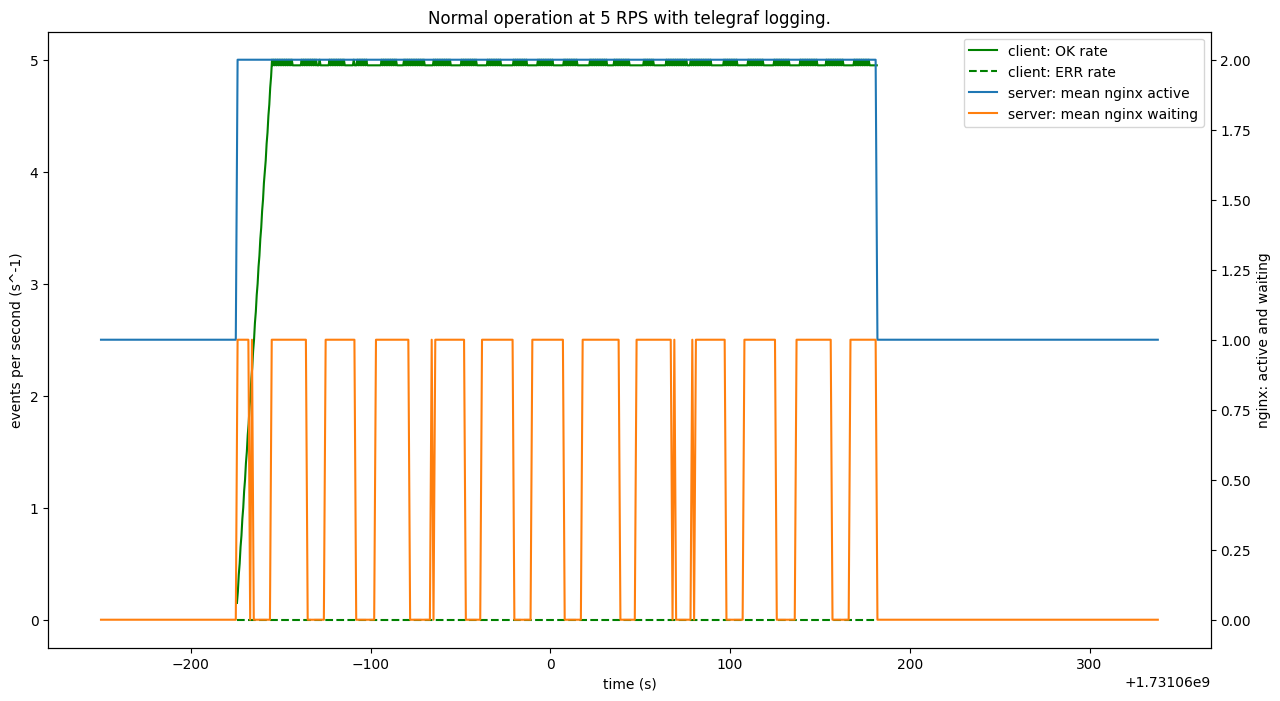

In [4]:
fig,ax = plot_utils.fig([
    Fig(title="Normal operation at 5 RPS with telegraf logging.",x="time (s)",y="events per second (s^-1)")
])

telegraf_log = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_09-57.json",
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})
client_log = LogFile(log_type=LogFileType.GOT, path="./logs/kleene/2024-11-08_09-57-05.147877.txt",kwargs={'color':'g'})

# plot nginx on new scale
ax_zoom = ax.twinx()
ax_zoom.set_ylabel('nginx: active and waiting')

plot_utils.overlay_rolling(ax_zoom, {'server': telegraf_log}, [mean_roller],0.5,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=0.5, times_units='s')

plot_utils.show_combined_legends([ax,ax_zoom])
fig.savefig('./plots/5_RPS.png')

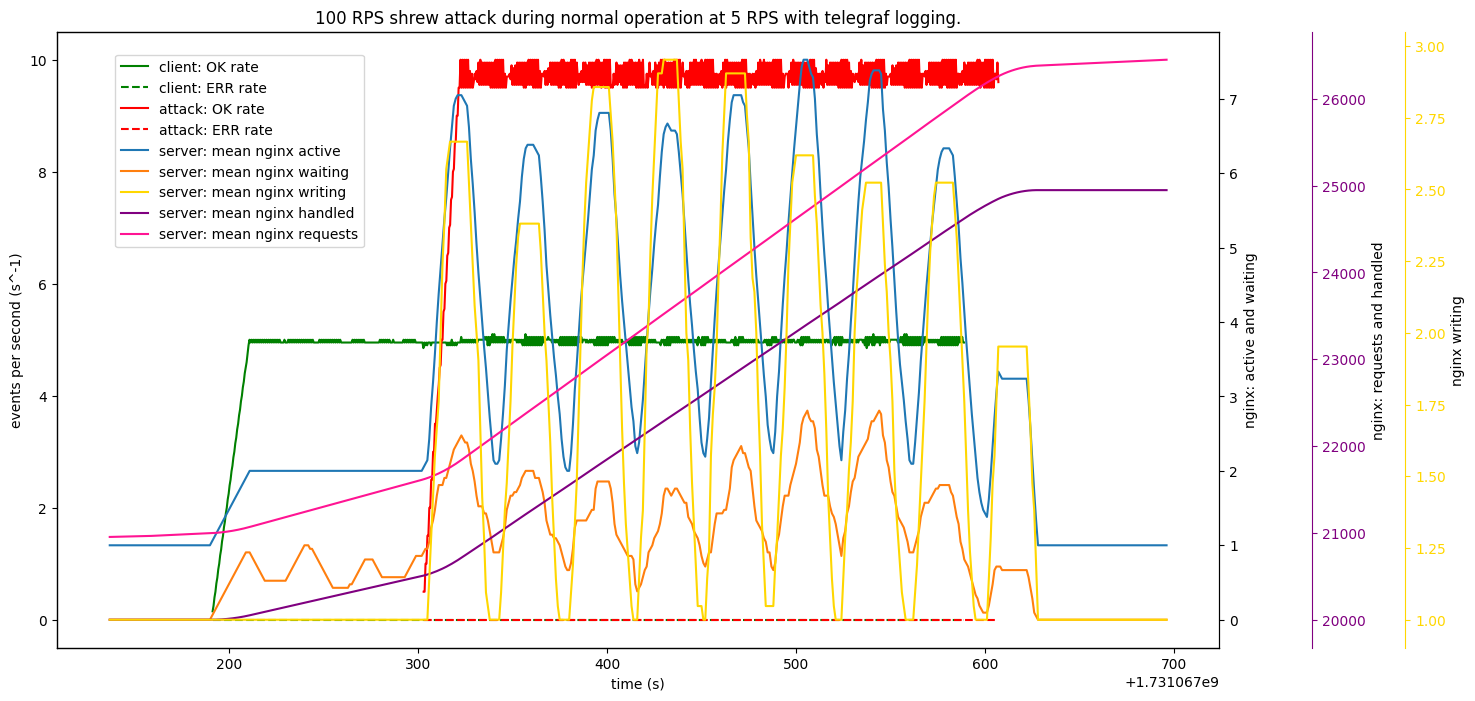

In [5]:
fig,ax = plot_utils.fig([
    Fig(title="100 RPS shrew attack during normal operation at 5 RPS with telegraf logging.",x="time (s)",y="events per second (s^-1)")
])

telegraf_log = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_11-59.json",
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})
nginx_handled = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_11-59.json",
kwargs={'telegraf': {
    'nginx' : [{'handled':{'color':'purple'}},{'requests':{'color':'deeppink'}}]
}, 'color':'purple'
})
nginx_writing = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-08_11-59.json",
kwargs={'telegraf': {
    'nginx' : ['writing']
}, 'color':'gold'
})
client_log = LogFile(log_type=LogFileType.GOT, path="./logs/kleene/2024-11-08_11-59-50.906225.txt",kwargs={'color':'g'})
attack_log = LogFile(log_type=LogFileType.GOT, path="./logs/mac/2024-11-08_12-01-42.533777.txt",kwargs={'color':'r'})

ax_active,ax_handled,ax_writing = plot_utils.add_y_axes(
    ax, [('nginx: active and waiting','black'),('nginx: requests and handled','purple'),('nginx writing','gold')]
)

plot_utils.overlay_rolling(ax_active, {'server': telegraf_log}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_writing, {'server': nginx_writing}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_handled, {'server': nginx_handled}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=0.5, times_units='s')
plot_utils.overlay_rolling(ax, {'attack': attack_log}, response_rollers, WINDOW_SECS, const_stride_secs=0.5, times_units='s')

plot_utils.show_combined_legends([ax,ax_active,ax_writing,ax_handled], loc=[0.05,0.65])
fig.savefig('./plots/100RPS_shrew_on_5RPS.png')